In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import math



In [3]:
users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
ratings=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/ratings.dat',sep="::",names=['UserID','MovieID','Rating','Timestamp'])

<ipython-input-3-4c609c110fe4>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
<ipython-input-3-4c609c110fe4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
<ipython-input-3-4c609c110fe4>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as rege

In [4]:

u=len(users)
m=max(movies["MovieID"])
r_train,r_test=train_test_split(ratings,test_size=0.1,stratify=ratings['UserID'])

# r_train.head()

In [5]:
user_item=np.full((u,m),np.nan)
for r in r_train.itertuples():
    user_item[r[1]-1][r[2]-1]=r[3]

user_item_test=np.full((u,m),np.nan)
for r in r_test.itertuples():
    user_item_test[r[1]-1][r[2]-1]=r[3]
# user_item

In [6]:
mean=np.nanmean(user_item,axis=1)
for i in range(m):
    user_item[i]=user_item[i]-mean[i]
    user_item_test[i] = user_item_test[i] - mean[i]

nan_cell=np.argwhere(np.isnan(user_item))

user_item=np.nan_to_num(user_item)

In [7]:
nan_list=[[] for i in range(u)]
for cell in nan_cell:
    nan_list[cell[1]].append(cell[0])
# nan_cell

In [8]:
def similarity(x,y):
    if np.dot(x,y)==0:
        return 0
    return np.dot(x,y)/math.sqrt(np.sum(x**2)*np.sum(y**2))

In [9]:
similarity_matrix=np.full((u,u),np.nan)
for user_1 in range(u):
    for user_2 in range(user_1+1):
        res=similarity(user_item[user_1],user_item[user_2])
        similarity_matrix[user_1][user_2]=res
        similarity_matrix[user_2][user_1]=res

similarity_matrix

array([[1.        , 0.03772631, 0.00121964, ..., 0.        , 0.01463444,
        0.02300043],
       [0.03772631, 1.        , 0.02743126, ..., 0.05623587, 0.02520585,
        0.02421147],
       [0.00121964, 0.02743126, 1.        , ..., 0.08992386, 0.00479186,
        0.01415352],
       ...,
       [0.        , 0.05623587, 0.08992386, ..., 1.        , 0.15127516,
        0.10553359],
       [0.01463444, 0.02520585, 0.00479186, ..., 0.15127516, 1.        ,
        0.21061228],
       [0.02300043, 0.02421147, 0.01415352, ..., 0.10553359, 0.21061228,
        1.        ]])

In [10]:
def predict(movie,user,k):
    copy=np.array(similarity_matrix[movie])

    np.delete(copy,nan_list[user])
    neighbor=(-copy).argsort()[1:k+1]
    similar=copy[neighbor]
    rate=user_item.T[user][neighbor]
    if np.sum(similar)!=0:
        return (rate@similar)/np.sum(np.abs(similar))
    return 0

In [11]:
def predict1(movie,user,k):
    copy=np.array(similarity_matrix[movie])
    np.delete(copy,nan_list[user])
    abs_copy=abs(copy)
    neighbor=(-abs_copy).argsort()[1:k+1]
    similar=copy[neighbor]
    rate=user_item.T[user][neighbor]
    if np.sum(similar)!=0:
        return (rate@similar)/np.sum(np.abs(similar))
    return 0

In [19]:
rmse = []
mae = []
precision = []
recall = []
NDCG = []
iteration_list = [1,5,10,15,30,50,100]
for k in iteration_list:
    similarity_matrix=np.nan_to_num(similarity_matrix)
    mean=np.nan_to_num(mean)
    para = 0
    se=0
    e = 0
    tp=0
    tp_fp=0
    tp_tn=0
    DCG = []
    IDCG = sorted(r_test['Rating'])[::-1]
    for r in r_test.itertuples():
        pred=predict1(r[1]-1,r[2]-1,k)
        user_item[r[1]-1][r[2]-1]=pred+mean[r[2]-1]
        DCG.append(pred+mean[r[2]-1])
        if pred>para:
            tp_fp+=1
        if r[3]>mean[r[2]-1]+para:
            tp_tn += 1
            if pred>para:
                tp+=1
        se+=(user_item[r[1]-1][r[2]-1]-r[3])**2
        e += math.fabs(user_item[r[1]-1][r[2]-1]-r[3])
    DCG = sorted(DCG)[::-1]
    NDCG.append(ndcg_score([IDCG], [DCG]))
    mae.append(e/len(r_test))
    rmse.append(math.sqrt(se/len(r_test)))
    precision.append(tp/tp_fp)
    recall.append(tp/tp_tn)

RMSE:  [2.339451313787214, 1.9562904325593522, 1.8664551015093451, 1.8275647404192528, 1.7682504988963486, 1.7230847728163898, 1.6558552774244062]


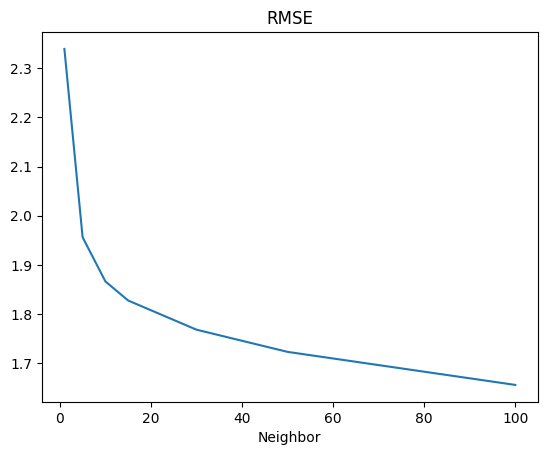

In [20]:
import matplotlib.pyplot as plt
from importlib import reload
print("RMSE: ",rmse)
plt=reload(plt)
plt.plot(iteration_list, rmse)
plt.xlabel('Neighbor')
plt.title('RMSE')
plt.show()

MAE:  [4.949780218285308e-05, 2.9644781094336732e-05, 3.253438178969517e-05, 3.1518420518009105e-05, 2.980929947175319e-05, 3.0498994822041417e-05, 2.8561201864394883e-05]


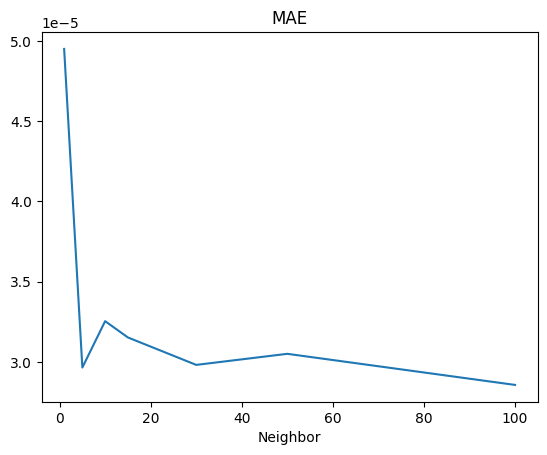

In [21]:
print("MAE: ",mae)
plt=reload(plt)
plt.plot(iteration_list, mae)
plt.xlabel('Neighbor')
plt.title('MAE')
plt.show()

Precision:  [0.5795251123045225, 0.5571637526362337, 0.5497425748253955, 0.5456299568850801, 0.5382238442822385, 0.5340344590900101, 0.5289036396348072]


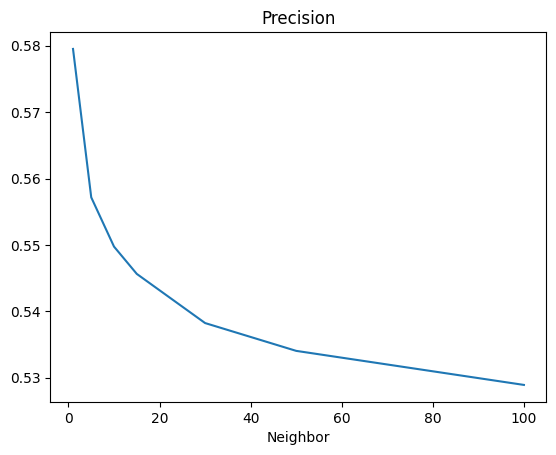

In [22]:
print("Precision: ",precision)
plt=reload(plt)
plt.plot(iteration_list, precision)
plt.xlabel('Neighbor')
plt.title('Precision')
plt.show()

Recall:  [0.3417179502499452, 0.6524267590766963, 0.763438290414451, 0.8166138893867878, 0.8811216665670869, 0.9142219832307662, 0.9426221345920217]


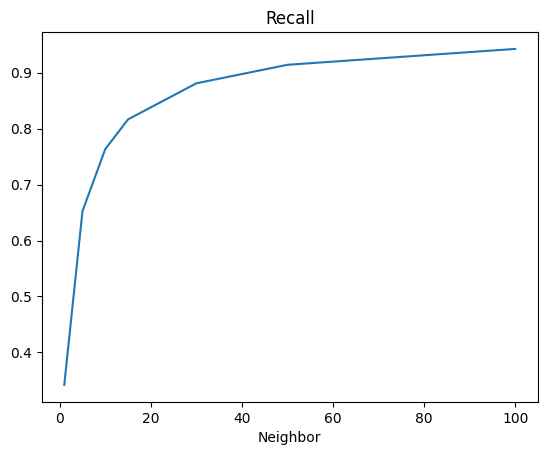

In [23]:
print("Recall: ",recall)
plt=reload(plt)
plt.plot(iteration_list, recall)
plt.xlabel('Neighbor')
plt.title('Recall')
plt.show()

NDCG:  [0.9999999653218853, 0.999999999937249, 0.9999999999921081, 0.9999999999901749, 0.9999999999999988, 0.999999999999999, 0.9999999999999987]


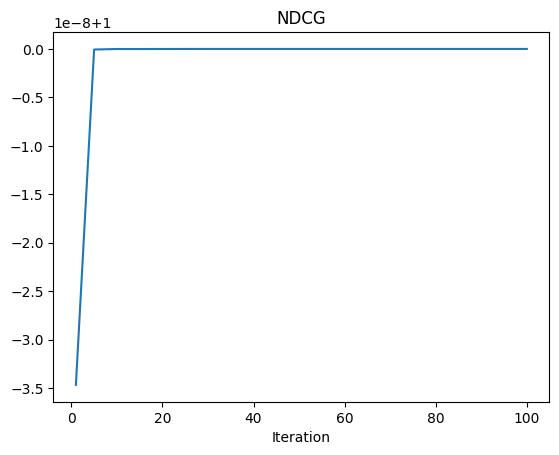

In [24]:
print("NDCG: ",NDCG)
plt=reload(plt)
plt.title('NDCG')
plt.plot(iteration_list,NDCG)
plt.xlabel("Iteration")
plt.show()